# Optimal Lookback Window

### Modules

In [2]:
import numpy as np
import pandas as pd
import math

import statsmodels
from statsmodels.tsa.stattools import coint
from statsmodels.tsa.vector_ar.vecm import coint_johansen
import statsmodels.api as stat
import statsmodels.tsa.stattools as ts

import matplotlib.pyplot as plt
from datetime import datetime, date

import seaborn as sb
import scipy.stats as stats

import warnings
warnings.filterwarnings('ignore')

### Import Data

In [3]:
# Import Data
assets = ['YFIUSDT', 'YFIIUSDT', 'ZECUSDT', 'XMRUSDT']
data = {}
prices_1h = {}

for asset in assets:
    data[asset] = pd.read_csv('./{}_1h.csv'.format(asset), index_col=0)
    data[asset].iloc[:,0] = pd.to_datetime(data[asset].iloc[:,0], unit='ms')
    prices_1h[asset] = pd.DataFrame({'date': data[asset].iloc[:,0], 'price': data[asset].iloc[:,3]})
    prices_1h[asset]['price'] = prices_1h[asset]['price'].apply(lambda x: math.log(x))
    

### Rolling Cointegration Functions

In [4]:
# Functions
def engle_granger_coint(A, B):
    result = stat.OLS(A, B).fit()
    a = ts.adfuller(result.resid)
    pvalue = a[1]
    return pvalue, result.params[0]


def johansen_coint(A, B):
    df = pd.DataFrame({'x': A, 'y': B})
    jres = coint_johansen(df, 0, 1)
    return jres.max_eig_stat[0], jres.max_eig_stat_crit_vals[0], jres.evec[0]


def cointegration(coint_type, confidence_interval, data_A, data_B):
    
    # Make data same size
    length_A = len(data_A)
    length_B = len(data_B)
    if length_A > length_B:
        data_A = data_A[(length_A-length_B):]
    elif length_B > length_A:
        data_B = data_B[(length_B-length_A):]
    
    data_A = list(data_A)
    data_B = list(data_B)
    
    
    if coint_type == 'engle-granger':
        pvalue, beta = engle_granger_coint(data_A, data_B)
        cointegrated = pvalue <= 1 - confidence_interval
        return cointegrated, beta

    elif coint_type == 'johansen':
        max_eig_value, max_eig_crit_val, eigenvectors = johansen_coint(data_A, data_B)
        if confidence_interval == 0.9:
            cointegrated = max_eig_value > max_eig_crit_val[0]
        elif confidence_interval == 0.95:
            cointegrated = max_eig_value > max_eig_crit_val[1]
        elif confidence_interval == 0.99:
            cointegrated = max_eig_value > max_eig_crit_val[2]
        else:
            raise Exception('Wrong convidence interval')
        return cointegrated, eigenvectors
    
    else:
        raise Exception('Wrong Cointegration Type')

        
def rolling_cointegration(coint_type, confidence_interval, data_A, data_B, lookback_window):
    
    dates = list(data_A['date'])

    # Make data same size
    length_A = len(data_A)
    length_B = len(data_B)
    if length_A > length_B:
        data_A = data_A[(length_A-length_B):]
    elif length_B > length_A:
        data_B = data_B[(length_B-length_A):]

    rolling_coint = {'date':[], 'cointegrated': [], 'beta': []}
    
    # Rolling Cointegration
    for i in range(len(dates)-1, 0, -1):
        if i - lookback_window >= 0:
            data_window_A = list(data_A['price'].iloc[i - lookback_window:i])
            data_window_B = list(data_B['price'].iloc[i - lookback_window:i])
            cointegrated, beta = cointegration(coint_type, confidence_interval, data_window_A, data_window_B)
            
            rolling_coint['date'].append(dates[i])
            rolling_coint['cointegrated'].append(cointegrated)
            rolling_coint['beta'].append(beta)

    return rolling_coint


def calculate_consecutive_candles(rolling_cointegration):
    
    candles_counter = 0
    cointegrated = False
    beta = []
    start_date = ''
    end_date = ''
    
    rolling_cointegration = pd.DataFrame(rolling_cointegration)
    consecutive_candles = {'start_date': [], 'end_date': [], 'nbr_of_candles': [], 'beta_median': []}
    
    for i in range(0, len(rolling_cointegration)):
        row = rolling_cointegration.iloc[i]
        if not cointegrated and row['cointegrated']:
            cointegrated = True
            end_date = row['date']
            beta.append(row['beta'])
        elif cointegrated and row['cointegrated']:
            candles_counter += 1
            beta.append(row['beta'])
        elif cointegrated and not row['cointegrated']:
            if candles_counter > 0:
                start_date = row['date']
                beta_median = pd.Series(beta).median()

                consecutive_candles['start_date'].append(start_date)
                consecutive_candles['end_date'].append(end_date)
                consecutive_candles['nbr_of_candles'].append(candles_counter)
                consecutive_candles['beta_median'].append(beta_median) #Careful with this if using johansen
        
            # Reset variables
            candles_counter = 0
            cointegrated = False
            beta = []
            start_date = ''
            end_date = ''
            
        else:
            pass
    
    return consecutive_candles



### Testing Functions

(False, 0.9320069913457096)
(False, array([10.16059468,  1.67764018]))


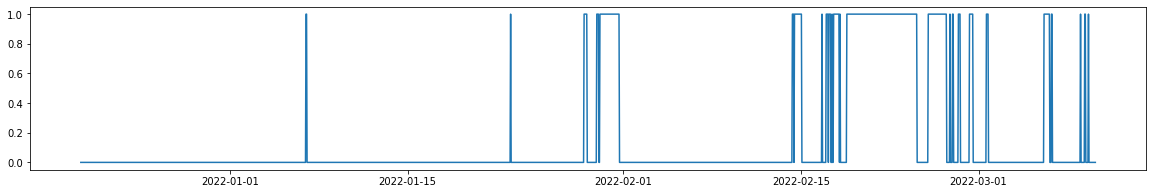

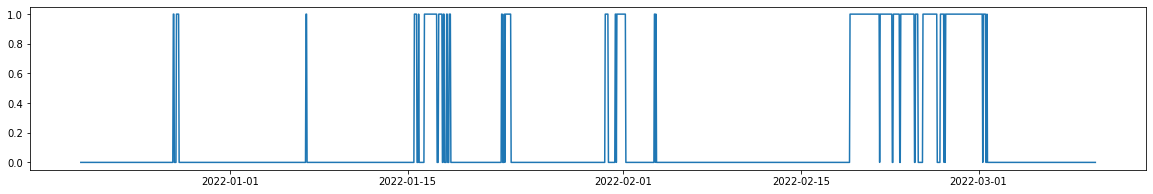

In [9]:
asset_A = 'ZECUSDT'
asset_B = 'XMRUSDT'
hist_window = 24*30*3
lb_window = 24*10
convidence_interval = 0.95
data_A = prices_1h[asset_A][(len(prices_1h[asset_A])-hist_window):]
data_B = prices_1h[asset_B][(len(prices_1h[asset_B])-hist_window):]
print(cointegration('engle-granger', convidence_interval, data_A['price'], data_B['price']))
print(cointegration('johansen', convidence_interval, data_A['price'], data_B['price']))

rolling_coint_eg = rolling_cointegration('engle-granger', convidence_interval, data_A, data_B, lb_window)

plt.figure(figsize=(20,3))
plt.plot(rolling_coint_eg['date'], rolling_coint_eg['cointegrated'])

rolling_coint_jo = rolling_cointegration('johansen', convidence_interval, data_A, data_B, lb_window)
plt.figure(figsize=(20,3))
plt.plot(rolling_coint_jo['date'], rolling_coint_jo['cointegrated'])



### Consecutive Candles Cointegrated

In [7]:
consecutive_candles_cointegrated_eg = pd.DataFrame(calculate_consecutive_candles(rolling_coint_eg))
consecutive_candles_cointegrated_eg.sort_values('nbr_of_candles', ascending=False)

,start_date,end_date,nbr_of_candles,beta_median
8,2022-02-18 14:00:00,2022-02-24 03:00:00,132,0.927390
14,2022-01-30 03:00:00,2022-01-31 16:00:00,36,0.904055
7,2022-02-25 00:00:00,2022-02-26 11:00:00,34,0.924878
12,2022-02-14 11:00:00,2022-02-15 01:00:00,13,0.929917
9,2022-02-17 13:00:00,2022-02-18 00:00:00,10,0.929091
2,2022-03-06 03:00:00,2022-03-06 14:00:00,10,0.927885
4,2022-02-28 06:00:00,2022-02-28 13:00:00,6,0.924198
16,2022-01-28 21:00:00,2022-01-29 03:00:00,5,0.905495
3,2022-03-01 14:00:00,2022-03-01 18:00:00,3,0.924064
5,2022-02-27 09:00:00,2022-02-27 13:00:00,3,0.924865


### Compare lookback periods

In [69]:
asset_A = 'ZECUSDT'
asset_B = 'XMRUSDT'
type_coint = 'engle-granger'
convidence_interval = 0.95
hist_window = 24 * 30 * 3

data_A = prices_1h[asset_A][(len(prices_1h[asset_A])-hist_window):]
data_B = prices_1h[asset_B][(len(prices_1h[asset_B])-hist_window):]

lookback_windows = range(175,275)
results = {'lookback_window': [], 'consecutive_candles_mean': [], 'consecutive_candles_median': []}

for i in lookback_windows:
    rolling_coint = rolling_cointegration(type_coint, convidence_interval, data_A, data_B, i)
    consecutive_candles_cointegrated = pd.DataFrame(calculate_consecutive_candles(rolling_coint))
    consecutive_candles_median = consecutive_candles_cointegrated['nbr_of_candles'].median()
    consecutive_candles_mean = consecutive_candles_cointegrated['nbr_of_candles'].mean()
    results['lookback_window'].append(i)
    results['consecutive_candles_median'].append(consecutive_candles_median)
    results['consecutive_candles_mean'].append(consecutive_candles_mean)
    print('lookback window: {}, consecutive candles median: {}, consecutive_candles_mean: {}'.format(i, consecutive_candles_median, consecutive_candles_mean))

results_df = pd.DataFrame(results)
results_df.sort_values(['consecutive_candles_mean', 'consecutive_candles_median'], ascending=False)[20:]

lookback window: 175, consecutive candles median: 6.0, consecutive_candles_mean: 15.384615384615385
lookback window: 176, consecutive candles median: 4.5, consecutive_candles_mean: 14.142857142857142
lookback window: 177, consecutive candles median: 5.0, consecutive_candles_mean: 15.461538461538462
lookback window: 178, consecutive candles median: 4.0, consecutive_candles_mean: 13.6
lookback window: 179, consecutive candles median: 4.5, consecutive_candles_mean: 14.428571428571429
lookback window: 180, consecutive candles median: 3.0, consecutive_candles_mean: 14.571428571428571
lookback window: 181, consecutive candles median: 2.0, consecutive_candles_mean: 11.333333333333334
lookback window: 182, consecutive candles median: 2.5, consecutive_candles_mean: 10.5
lookback window: 183, consecutive candles median: 3.0, consecutive_candles_mean: 13.666666666666666
lookback window: 184, consecutive candles median: 3.0, consecutive_candles_mean: 12.058823529411764
lookback window: 185, consec

lookback window: 261, consecutive candles median: 9.5, consecutive_candles_mean: 20.055555555555557
lookback window: 262, consecutive candles median: 8.0, consecutive_candles_mean: 21.470588235294116
lookback window: 263, consecutive candles median: 4.0, consecutive_candles_mean: 17.666666666666668
lookback window: 264, consecutive candles median: 6.0, consecutive_candles_mean: 18.5
lookback window: 265, consecutive candles median: 5.0, consecutive_candles_mean: 17.904761904761905
lookback window: 266, consecutive candles median: 7.0, consecutive_candles_mean: 20.77777777777778
lookback window: 267, consecutive candles median: 7.0, consecutive_candles_mean: 22.176470588235293
lookback window: 268, consecutive candles median: 7.0, consecutive_candles_mean: 19.894736842105264
lookback window: 269, consecutive candles median: 9.0, consecutive_candles_mean: 24.0
lookback window: 270, consecutive candles median: 7.0, consecutive_candles_mean: 20.210526315789473
lookback window: 271, consecu

,lookback_window,consecutive_candles_mean,consecutive_candles_median
88,263,17.666667,4.0
26,201,17.454545,3.0
32,207,17.090909,2.0
17,192,17.000000,3.0
23,198,16.750000,4.0
...,...,...,...
38,213,10.333333,3.0
39,214,9.818182,3.5
36,211,9.714286,2.0
37,212,9.545455,2.5


In [70]:
# Lookback window average weighted by mean and median
max_median = results_df['consecutive_candles_median'].max()
max_mean = results_df['consecutive_candles_mean'].max()
results_df['weights_median'] = results_df['consecutive_candles_median'].apply(lambda x: x / max_median)
results_df['weights_mean'] = results_df['consecutive_candles_mean'].apply(lambda x: x / max_mean)
print('optimal lookback weighted by mean: {}'.format(np.average(results_df['lookback_window'], weights=results_df['weights_mean'])))
print('optimal lookback weighted by median: {}'.format(np.average(results_df['lookback_window'], weights=results_df['weights_median'])))

optimal lookback weighted by mean: 226.85660551940938
optimal lookback weighted by median: 229.86559802712705


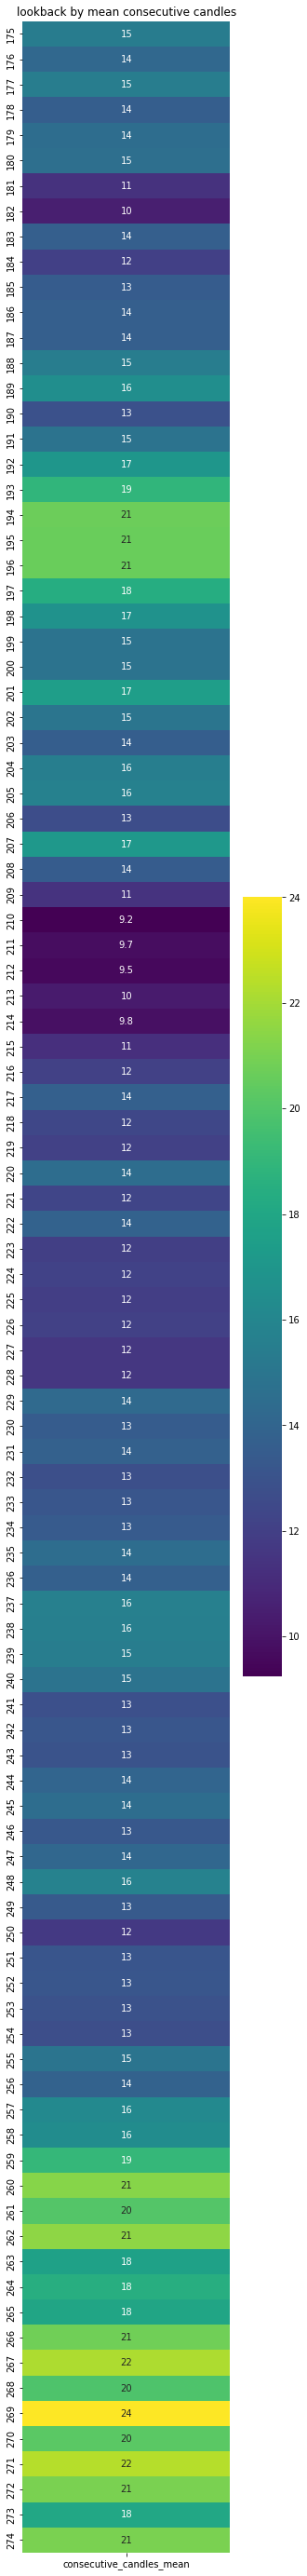

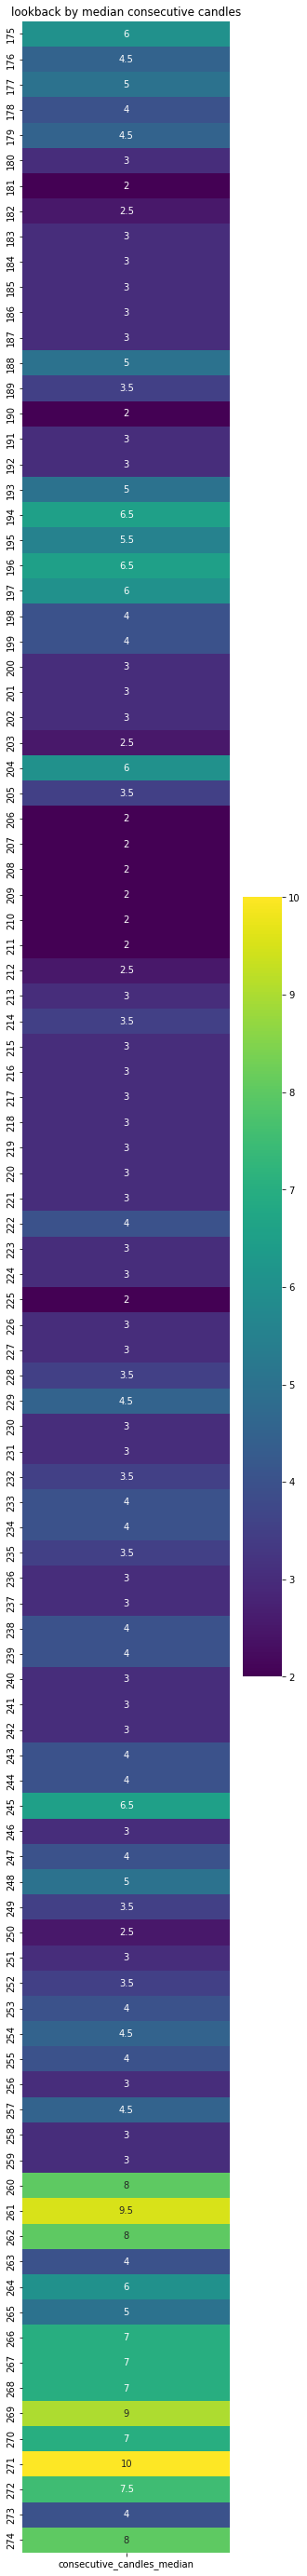

In [71]:
df_mean = pd.DataFrame({'consecutive_candles_mean': list(results['consecutive_candles_mean'])}, index=list(results['lookback_window']))
df_median = pd.DataFrame({'consecutive_candles_median': list(results['consecutive_candles_median'])}, index=list(results['lookback_window']))

plt.figure(figsize=(5,50))
plt.title('lookback by mean consecutive candles')
sb.heatmap(df_mean, annot=True, cmap="viridis")
plt.show()

plt.figure(figsize=(5,50))
plt.title('lookback by median consecutive candles')
sb.heatmap(df_median, annot=True, cmap="viridis")
plt.show()

In [ ]:
#best so far 194-195-196 lookback with 21 average consecutive candles
#260-274